In [73]:
# It is needed to create the obs (head) data for the .pst file for flow model optimization
# It will also be needed to create the obs (age) data for the .pst file for transport model optimization
# 
% matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import os
import flopy as fp
import subprocess as sp

In [74]:
os.getcwd()

'C:\\Users\\Mohsen'

In [75]:
# Insert name of data file -if SGEMS use name of exported CSV file
data = np.loadtxt('AA_FTestNewSimK', skiprows=1)

In [76]:
data

array([ 4.54677,  4.57565,  4.57176, ...,  6.17157,  6.14521,  6.18599])

0.18490155905734182

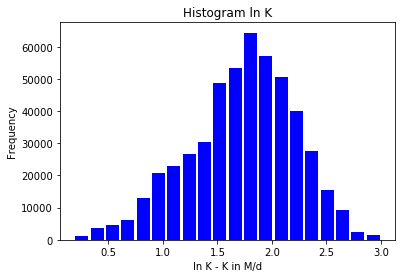

In [77]:
# Do histogram early - before reshaping - later one does not work
lndata = np.log(data)
plt.hist(lndata, 20,rwidth=0.85, color='Blue')
plt.title("Histogram ln K")
plt.xlabel("ln K - K in M/d")
plt.ylabel("Frequency")
fig = plt.gcf()
# Minimum ln value
minln = lndata.min()
minln


1.2031000000000001

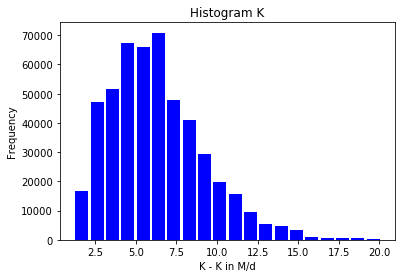

In [79]:
# histogram for K
ddata = data
plt.hist(ddata, 20,rwidth=0.85, color='Blue')
plt.title("Histogram K")
plt.xlabel( "K - K in M/d")
plt.ylabel("Frequency")
fig = plt.gcf()
# Minimum ln value
min = ddata.min()
min

In [80]:
# Reshape data to match modflow 2D K-array: 500 rows (x),1000 columns(y)
nrow = 500
ncol = 1000
nlay = 1
data = data.reshape(nrow,ncol)[::-1]


In [81]:
data

array([[ 12.3473 ,  12.3496 ,  12.4445 , ...,   6.17157,   6.14521,
          6.18599],
       [ 12.4218 ,  12.4038 ,  12.3859 , ...,   6.07676,   6.10235,
          6.09059],
       [ 12.4352 ,  12.4128 ,  12.4057 , ...,   6.04605,   6.02746,
          6.06188],
       ..., 
       [  4.65467,   4.67207,   4.69169, ...,   6.98886,   7.01303,
          6.96291],
       [  4.645  ,   4.64063,   4.62868, ...,   6.99395,   6.98186,
          6.96227],
       [  4.54677,   4.57565,   4.57176, ...,   7.02553,   7.00612,
          6.93373]])

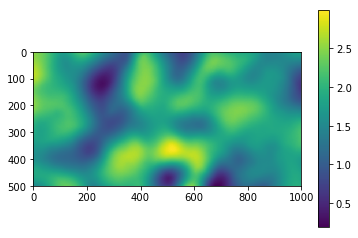

In [82]:
# Check view of data as 2D plot - in numpy "log" is natural log; log base 10 is "log10"
# This should resemble plots made of the same reality in SGEMS

lndata = np.log(data)
plt.imshow(lndata, interpolation='Nearest')
plt.colorbar()

In [83]:
lndata

array([[ 2.51343742,  2.51362367,  2.52127876, ...,  1.81995326,
         1.81567292,  1.82228706],
       [ 2.51945299,  2.51800288,  2.51655873, ...,  1.80447166,
         1.80867394,  1.80674496],
       [ 2.52053116,  2.5187282 ,  2.51815604, ...,  1.79940517,
         1.79632569,  1.80201998],
       ..., 
       [ 1.53787102,  1.54160223,  1.54579286, ...,  1.94431745,
         1.94776985,  1.94059749],
       [ 1.53579137,  1.53485013,  1.53227173, ...,  1.94504549,
         1.94331536,  1.94050557],
       [ 1.51441709,  1.52074877,  1.51989825, ...,  1.94955066,
         1.94678405,  1.93639791]])

In [84]:
# Check min ln value 
minln = lndata.min()
minln

0.18490155905734182

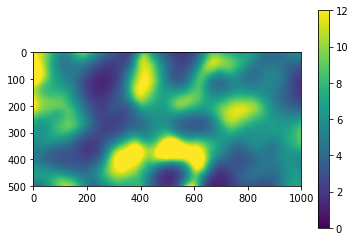

In [85]:
# Plot 2D K values
plt.imshow(data, interpolation='Nearest', vmin=0, vmax=12)
plt.colorbar()


In [86]:
# Maximum K value
maxdata = data.max()
maxdata

20.081299999999999

In [87]:
# Modflow-NWT set up and run - change modelname for new runs  
# Create model files and run modflow

ml = fp.modflow.Modflow(modelname='C_Flow1',version = 'mfnwt', exe_name ='C:/WRDAPP/MODFLOW-NWT_1.0.9/bin/MODFLOW-NWT_64.exe')
name = 'C_Flow1'
# Inititialize variables
h = 1
k = 1
h1 = 30
bot = -30
delrow = 1
delcol = 1
hk = data
# Set head for start of flow
head_left = 30.
# Set head for end of flow
head_right = 20.
# Set iniital head for all cells 
head_initial_all = 25.

# Create high K at left and right boundaries - 2 orders of mag > maximum input K 
maxdata = data.max()
hk[:, 0] = maxdata*100
hk[:, -1]= maxdata*100

# Call Modflow dis routine to create .dis file
dis = fp.modflow.ModflowDis(ml, nlay = 1, nrow=nrow, ncol = ncol, delr = delrow, delc=delcol, top = 0, botm = bot, laycbd=0)
#
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1   
ibound[:, :, -1] = -1   

# Create array for starting head values
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)

# Change starting head for all cells to initial value  
strt[:,:,:] = head_initial_all
# Then change starting head for column 0 to head_head 
strt[:, :, 0] = head_left
# Then change starting head for last column to head_right
strt[:, :, -1] = head_right

# Add pumping well with discharge equals 500 cubic meter per day
lrcq = {0:[0, 199, 699, -500.0]}
wel = fp.modflow.ModflowWel(ml, ipakcb=53, stress_period_data=lrcq, extension='wel', unitnumber=20)


# Call Modflow Basic routine to create .bas file
bas = fp.modflow.ModflowBas(model=ml,ibound=ibound, strt=strt,ixsec=False,ichflg=True, stoper=None, hnoflo=-999.99,extension = 'bas', unitnumber=13)


oc = fp.modflow.ModflowOc(ml, ihedfm=0, iddnfm=0, chedfm=None, cddnfm=None, cboufm=None, 
                              compact=True, stress_period_data={(0, 0): ['save head', 'save budget']}, 
                              extension=['oc', 'hds', 'ddn', 'cbc'], unitnumber=[14, 51, 52, 53])
oc

# Changed head tolerance to .001   
# Call Modflow Nwt routine to create .nwt file 
nwt = fp.modflow.ModflowNwt(ml, headtol=0.001, fluxtol=500, maxiterout=100, 
                                thickfact=1e-05, linmeth=2, iprnwt=1, ibotav=0, options='COMPLEX')


# Change layer type to 0
# Change 'iupwcb=53' to 'ipakcb=53' 
# Call Modflow upw routine to create .upw file
upw = fp.modflow.ModflowUpw(ml, laytyp=0, layavg=0, chani=1.0, layvka=1, laywet=0, ipakcb=53, 
                                hdry=1, iphdry=1, hk=hk, hani=1.0, vka=1.0, 
                                noparcheck=False, extension='upw', 
                                unitnumber=31)
#
ml.write_input()

# Run Modflow with files created above
success,output = ml.run_model()
 

FloPy is using the following executable to run the model: C:/WRDAPP/MODFLOW-NWT_1.0.9/bin/MODFLOW-NWT_64.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.2, 9/15/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: C_Flow1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/03/11 16:48:15

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/03/11 16:49:15
 Elapsed run time: 59.624 Seconds

  Normal termination of simulation


In [88]:
print("ml_run_model = %s" % success)

ml_run_model = True


In [89]:
# Insert name of modflow output formatted head data file 
head_file = 'C_Flow1.hds'
head_object = fp.utils.HeadFile(head_file)
heads = head_object.get_data()

In [90]:
heads

array([[[ 30.        ,  29.99760437,  29.99285507, ...,  20.01011086,
          20.00337982,  20.        ],
        [ 30.        ,  29.99761009,  29.99285889, ...,  20.01010704,
          20.0033741 ,  20.        ],
        [ 30.        ,  29.99761009,  29.99285889, ...,  20.01010704,
          20.00337791,  20.        ],
        ..., 
        [ 30.        ,  29.99305153,  29.97920036, ...,  20.00690079,
          20.00230408,  20.        ],
        [ 30.        ,  29.99306107,  29.97920799, ...,  20.00690842,
          20.00230789,  20.        ],
        [ 30.        ,  29.99306297,  29.97921181, ...,  20.00691414,
          20.00231171,  20.        ]]], dtype=float32)

In [91]:
# Head of groundwater at this point (well)
heads[0,199,699]

19.751289

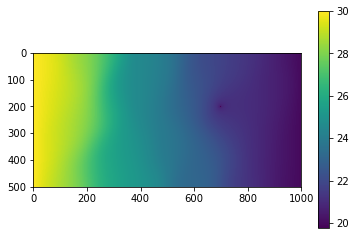

In [92]:
plt.imshow(heads[0, :, :], interpolation='Nearest')
plt.colorbar()

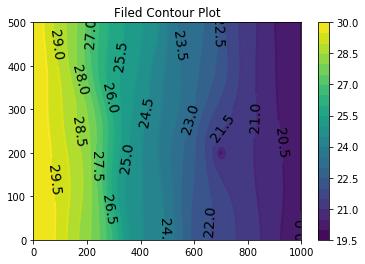

In [93]:
origin = 'lower'
CS1 = plt.contour(heads[0, :, :], 20,
                 #colors=('k',),
                  linewidths=(2,),
                  origin=origin)
CS2 = plt.contourf(heads[0, :, :],20)

plt.title('Filed Contour Plot')
plt.clabel(CS1, fmt='%2.1f', colors='k', fontsize=14)

#CS1 = plt.contourf(heads[0, :, :],10)
plt.colorbar(CS2)

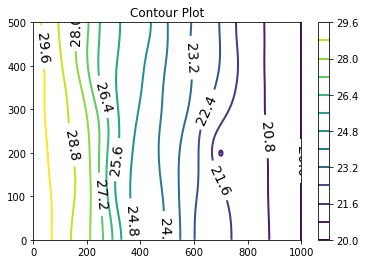

In [94]:
#origin = 'lower'
CS1 = plt.contour(heads[0, :, :], 15,
                 #colors=('k',),
                  linewidths=(2,),
                  origin=origin)
#CS2 = plt.contourf(heads[0, :, :],20)

plt.title('Contour Plot')
plt.clabel(CS1, fmt='%2.1f', colors='k', fontsize=14)

#CS1 = plt.contourf(heads[0, :, :],10)
plt.colorbar(CS1)

To create observations, first make a matrix of grid coordinates using a flopy method of the dis object and using meshgrid to flesh out the coordinate arrays. Then sample them using a step size of 50. Also sample the heads using a step size of 50, et voila, you have an observation data set.

from random import randint

seen = set()

for i in range(0,50 ):
    x, y , z = randint(25, 475), randint(25, 975), randint(0, 0)
    seen.add((z, x, y))
    i+=i
a= list(seen)
a = np.array(a)
#a = a+0.5
#a

np.save('RandomObs', a)

#np.save('RandomObs.npy', a)

In [95]:
a = np.load('RandomObs.npy')

In [96]:
#a[49,2] #Answer = 404
#a.shape #Answer = (50,3)
#heads[0,  41, 434]
#b = a.flatten()[4]
b = a[:,0]

c= a[:,1]

d= a[:,2]

b,c,d

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]),
 array([269, 179, 140,  94, 216, 417, 176, 405, 279,  70, 406, 395, 220,
        308,  38,  75, 433,  27,  38, 310, 338, 364, 173, 218, 346, 416,
        102, 411, 451, 425,  35, 434, 181, 141, 176,  75,  47, 184,  46,
        392, 166, 354, 312, 259, 209, 320, 114, 346, 213, 176]),
 array([196,  77, 703,  63, 790, 472, 706, 656, 285, 891, 605, 296, 338,
        497, 450, 653, 659, 185, 307, 675,  71, 701, 373, 889, 874, 347,
        286, 957, 172, 326, 190, 589, 218, 445, 816, 334, 505, 436,  55,
         54, 602, 232, 151, 261,  65, 510, 542, 594, 966, 243]))

In [97]:
#Find index positions where 3D-array meets MULTIPLE conditions

index_pos = np.where((heads[:,:,:]==19.751289)) #& (heads[:,1]== 473) & (heads[:,2]==459))
index_pos

(array([0], dtype=int64), array([199], dtype=int64), array([699], dtype=int64))

In [98]:
head_obs = heads[b,c,d]
head_obs

array([ 28.10085106,  29.42650795,  21.50626373,  29.63387871,
        21.10994148,  24.25179863,  21.17774391,  22.79533386,
        26.22420692,  20.72533798,  23.11175156,  25.72019005,
        25.27002525,  23.87481308,  24.29122353,  22.06710243,
        22.82064056,  28.33154106,  25.98452759,  22.17912865,
        29.31162453,  22.21613121,  24.73497963,  20.71090698,
        20.72928047,  25.35579681,  26.13246918,  20.20901108,
        27.7673645 ,  25.52124977,  28.28478432,  23.18832016,
        27.85590553,  24.25201035,  21.02971458,  25.17673874,
        23.81898117,  24.28756142,  29.70381165,  29.45230865,
        22.55241394,  26.80316544,  28.55704117,  26.83341789,
        29.49299812,  23.79561615,  23.21359825,  23.15140533,
        20.23247528,  27.24829292], dtype=float32)

In [99]:
#x, y = np.meshgrid(c, d)

obs_data = np.array(list(zip(d.ravel(), c.ravel(), head_obs.ravel())))

In [100]:
obs_data

array([[ 196.        ,  269.        ,   28.10085106],
       [  77.        ,  179.        ,   29.42650795],
       [ 703.        ,  140.        ,   21.50626373],
       [  63.        ,   94.        ,   29.63387871],
       [ 790.        ,  216.        ,   21.10994148],
       [ 472.        ,  417.        ,   24.25179863],
       [ 706.        ,  176.        ,   21.17774391],
       [ 656.        ,  405.        ,   22.79533386],
       [ 285.        ,  279.        ,   26.22420692],
       [ 891.        ,   70.        ,   20.72533798],
       [ 605.        ,  406.        ,   23.11175156],
       [ 296.        ,  395.        ,   25.72019005],
       [ 338.        ,  220.        ,   25.27002525],
       [ 497.        ,  308.        ,   23.87481308],
       [ 450.        ,   38.        ,   24.29122353],
       [ 653.        ,   75.        ,   22.06710243],
       [ 659.        ,  433.        ,   22.82064056],
       [ 185.        ,   27.        ,   28.33154106],
       [ 307.        ,   38.

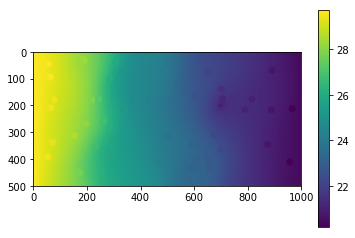

In [101]:
plt.imshow(heads[0, :, :], interpolation='Nearest')
plt.scatter(obs_data[:,0], obs_data[:,1], c=obs_data[:,2])
plt.colorbar()

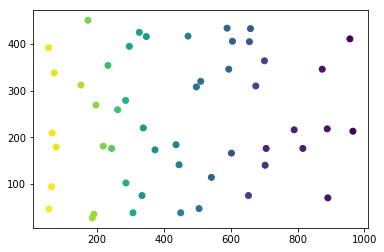

In [102]:
#plt.imshow(heads[0, :, :], interpolation='Nearest')
plt.scatter(obs_data[:,0], obs_data[:,1], c=obs_data[:,2])
#plt.colorbar()

In [103]:
len(obs_data)

50

In [104]:
#Add random error to observations with mean =0, std-dev = # variant (check different numbers)
meas_error=np.random.normal(0.0,0.0001,size = 50)
print(meas_error[0:5])

[ -1.63771080e-05   3.98403357e-05  -5.34974573e-05  -1.42099620e-05
  -4.80453034e-05]


#### Create text file of Observations formatted for PEST to place in .pst control file

In [105]:
fp = open('D_Flow1HeadObs.txt','w')
obs = np.zeros(len(obs_data))
for num in range(0,len(obs_data)):
    obsname = "hd" + str(num) 
    obs[num]= obs_data[num,2]+ meas_error[num]
    row = obs_data[num,0]
    col = obs_data[num,1]
    # Weight = 1.0
    fp.write("%10s %11s %5s %7s %5s %5s\n" % (obsname, str(obs[num]), str(1.0), "heads", str(row), str(col)))
fp.close()

In [106]:
# Create content of instruction (.inst) file for PEST
fp=open('D_Flow1.inst','w')
for num in range (0,len(obs_data)):   
    obsname = "hd" + str(num)
    fp.write("%s %s \n" % ("l1", "("+obsname+")"+"11:22") )
fp.close()
